## SOP - Cell Deconvolution and Differential Gene Expression Analysis 

This SOP follows from the previous one, where the data has already been processed, normalized and QC filtering has been performed. This will be a step-by-step guide on how to extract meaningful information from the data. This part of the SOP is written in R instead of Python. 

# Step 1 - Loading Libraries
For SpatialDecon and GeomxTools, R's Bio Conductor package manager is necessary to have. These should be installed into the R environment prior. Other packages may be installed using conda. dplyr may not be necessary, but makes some processing steps easier (e.g. turning the data into a long format). 

In [2]:
library(ggplot2)
library(SpatialDecon)
library(GeomxTools)
library(pheatmap)
library(readxl)
library(lme4)
library(stringr)
library(multcomp)
library(lmerTest)
library(ggrepel)

library(tidyr)
library(dplyr)
library(readr)

# Step Two - Loading In Datasets
"logNormData" is a csv file containing gene expression data. It should be normalized using the Python SOP. Each row is a gene, and each column is an AOI. The AOI name contains the slide name, sample/ROI number and segment separated by "..." In addition, 
the "TargetName" column contains the gene names. This column name may differ from data, but it is crucial that the name is correct to avoid bugs when data processing. 

"sunny_bioqc.xlsx" in this instance is an excel file containng multiple sheets. "TargetProperties" contains info about targets. "Segment Properties" contains info on each sample, such as the panCk/cd45 staining which is the most relevant for this step. The AOI nuclei count is also important - in this instance the column is named AOINucleiCount

"read_excel" is part of the readxl package. It's important to specify the sheet name. 

In [3]:
# Load in datasets


normData <- read.csv("./logNormData")
targetProperties <- read_excel("./sunny_bioqc.xlsx", sheet = "TargetProperties")
segmentProperties <- read_excel("./sunny_bioqc.xlsx", sheet = "SegmentProperties")

# Rename the column to "TargetName" if not already the case. Replace the TargetName (no quotes) with current name 

normData <- rename(normData, "TargetName" = TargetName)

negativeProbeName <- "Negative Probe"

segmentNames <- c("Segment.1", "Segment.2")




# Step 3 - Define Functions

These functions have been made to better process the data. These are not necessary but may be useful to save time. 

In [4]:
# ExtractSegment takes in as argument a list of sample names, and creates a list of the same size where 
# every element of the list includes only the segment name. It then renames the segment (optional). 
# Example: 
# sampleColNames <- c("10...01...SegA", "10...02...SegA",
#                    "15...01...SegB", "15...02...SegB")

# segmentNames <- c("SegA", "SegB")

# Let's say we want SegA to be panCK and SegB to be cd45. Then, renameSegment is defined:
# renameSegment <- c("panCK", "cd45")

# Output: c("panCK", "panCK", "cd45", "cd45")

ExtractSegment <- function(sampleColNames, segmentNames, renameSegment = segmentNames){

workingList <- c(rep(NA, length(sampleColNames)))

for (i in c(1:length(segmentNames))){

    segBool <- grepl(segmentNames[i], sampleColNames)
    workingList[which(segBool)] = renameSegment[i]
    
}

    return(workingList)
    }

# Label samples takes a vector sampleNames (i.e. from dataframe$sample) which contains the slide name of each sample. 
# The purpose of this function is to create an annotation based on the slide names. This is done using the annotationFrame
# object, which is a dataframe where each column name is a label and each row is a slide name corresponding to that label. 
# The function returns a vector of the same size as the number of samples, where each element is the corresponding label. 
# It should be added as a column to a dataframe that annotates the heatmap (in this notebook it is called testcat). 

# Example: for the annotationFrame <- data.frame(progressor = c("1", "2"), non_progressor = c("3"), unknown = c("4"))
    # with sampleNames <- c('1', '1', '3', '2', '4', '3', '3', '4', '1', '3')

# The output will be c('progressor', 'progressor', 'non_progressor', 'progressor', 
#'unknown', 'non_progressor', 'non_progressor', 'unknown', 'progressor', 'non_progressor')

LabelSamples <- function(sampleNames, annotationFrame){

    output <- c(rep(NA, length(sampleNames)))

    for (i in c(1:length(colnames(annotationFrame)))){

    labelBool <- sampleNames %in% (annotationFrame[,i])
    output[which(labelBool)] <- colnames(annotationFrame)[i]
    }
    

    return(output)
}



# Step 4 - Cell Deconvolution Heatmaps 

This section requires some data processing to incorporate the pheatmap function. For the annotated heatmap, pheatmap is used. For annotation, this dataset has progressor or non-progressor labels associated with each slide. The labels are as follows:

10233 4 and 101287 2 are progressors

98016 2 and 107466 2 are non-progressors

variable names: 

spacialDeconTest is the spatialdecon object 

testcat is a dataframe where each row is a samplea and each column is an annotation of that sample

annFrame is a dataframe where each column is a slide label and each row is a slide name

testing is the plottable data (after running sweep on spacialDeconTest) using pheatmap


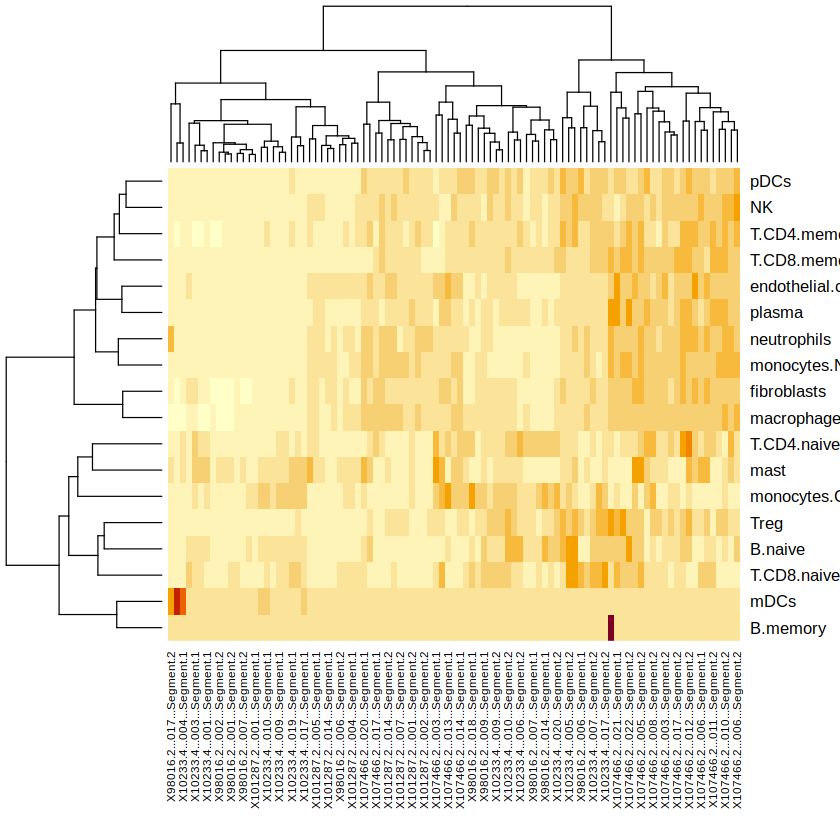

In [5]:
row.names(normData) = normData$TargetName # For the heatmap, the row names need to be the gene names

normData$TargetName <- NULL # Don't need these columns, want each to be numeric
normData$X <- NULL

bg = derive_GeoMx_background(norm = normData,
                             probepool = targetProperties$ProbePool,
                             negnames = negativeProbeName)
# Derive the background using spatial decon package


normMat <- as.matrix(normData) # The data needs to be a matrix to be used in the spatialdecon function

cellCountVec <- segmentProperties$AOINucleiCount # The AOI Nuclei count is needed. This may be named something different

spacialDeconTest <- spatialdecon(normMat, bg, cell_counts = cellCountVec) 

renamedlist <- ExtractSegment(sampleColNames = colnames(spacialDeconTest$t), segmentNames = c("Segment.1", "Segment.2"), 
    renameSegment = c("panCK", "CD45"))

heatmap(sweep(spacialDeconTest$t, 1, apply(spacialDeconTest$t, 1, max), "/"), margins = c(10,5))


Cell type deconvolution heatmap. This uses the default cell types presented in the SpatialDecon package. The dataset contains areas high in immune cell types, and areas high in tumor cell types. This creates a contrast in the samples where the left side of the heatmap appears much lighter than the right side. This backs up the idea that some samples are progressors and some are non-progressors, and the cell proportion may be used to reflect that. It may also be useful to explore different cell types, such as subtypes of B and T cells. 

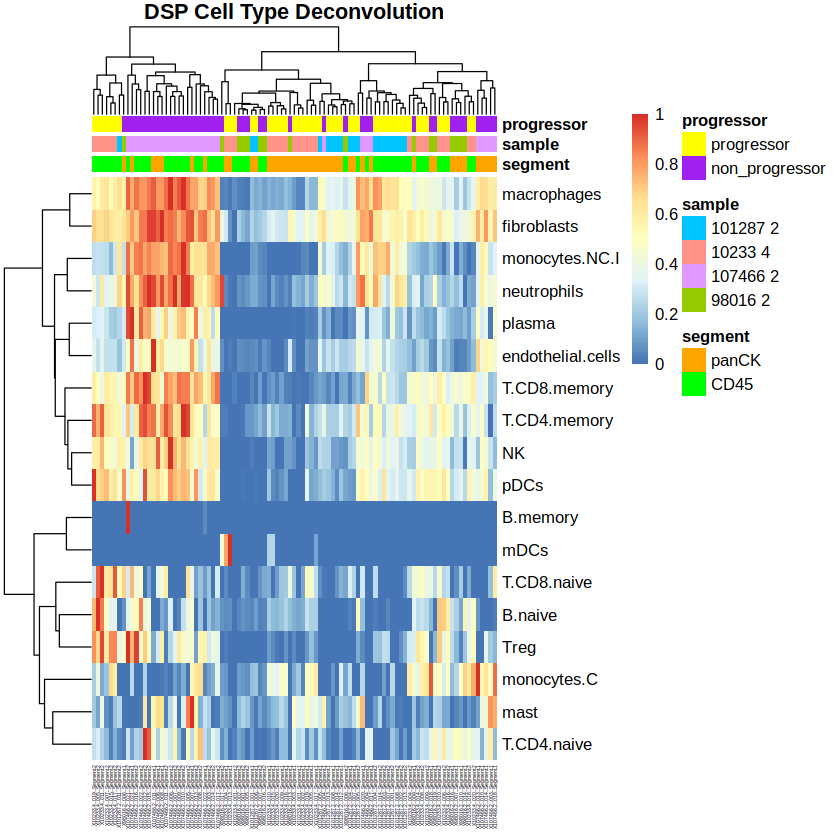

In [6]:
# Labelling samples as progressor and non-progressor 
annFrame <- data.frame(progressor = c("10233 4", "101287 2"), non_progressor = c("98016 2", "107466 2"))

testcat <- data.frame(segment = renamedlist)

# Note: ScanLabel is the sample name unique to each slide. 
testcat$sample <- segmentProperties$ScanLabel

testcat$progressor <- LabelSamples(sampleNames = testcat$sample, annotationFrame = annFrame)

testing <- sweep(spacialDeconTest$t, 1, apply(spacialDeconTest$t, 1, max), "/")

row.names(testcat) = colnames(spacialDeconTest$t)

# Annotation Colors.
# This section isn't necessary, but can make the annotation more clear in the heatmap. 

ann_colors = list(
    segment = c(panCK = "orange", CD45 = "green"),
    progressor = c(progressor = "yellow", non_progressor = "purple")
)

pheatmap(testing, annotation = testcat, annotation_colors = ann_colors, angle_col = "90", fontsize_col = 3, fontsize = 10,
        main = "DSP Cell Type Deconvolution")


As above, the heatmap shows cell deconvolution across every sample. This heatmap uses the pheatmap function. To get the annotations, it is necessary to have another data frame where the rows are sample names and the columns contain sample information (i.e. progressor, segment). The rownames are present as the column names of the gene x sample matrix, and can be used to make the annotation dataframe. Any number of sample annotations is possible, although it is preferrable to have these annotations in the segment properties dataframe for easy mapping. The sample names may also be different, so it's important to keep track of how the data is processed. 

# Step 5 - Differential Gene Expression Analysis

Classes to compare:

    panCK progressor vs panCK non-progressor

    cd45 progressor vs cd45 non-progressor

    cd45 progressor vs panCK progressor ----------|
                                                  | ---- "Sanity Check"
    cd45 non-progressor vs panCK non-progressor --|

The first step of DGE is to make the data into a long format. Then, the data is filtered to include only the ROIs that fit one of four conditions. Each gene is then compared between conditions using lme, and the resulting p-values and log fold change between conditions is recorded in a final data table. These results are used to create the volcano and heatmap results for each of the four comparisons. 

In [27]:
# Code to longify the data. Written to csv on PSC so can just load that in 
normData$TargetName <- rownames(normData)

longData <- normData %>% pivot_longer(!TargetName, names_to = "sample", values_to = "count")

longData$segment <- grepl("Segment.1", longData$sample)

testLong <- (longData)

#write.csv(x = testLong, '/jet/home/gfonseca/repos/UPMC HCC/testLong.csv')



In [28]:
# Divide the data based on progressor, found in sample name 

p1 <- grepl("10233", longData$sample)
p2 <- grepl("101287", longData$sample)

progressor <- (p1 | p2)
longData$progressor <- progressor

In [ ]:
# DGE analysis below 

In [29]:
longData <- read.csv("./testLong.csv")

# make slide value (could get from segment properties but this is safer)
longData$slide <- str_split_fixed(longData$sample, "\\.", 2)[,1]


In [30]:
# build featureDfs, holds the different classes to compare 
panCKonly <- (longData[longData$segment,])
cd45only <- longData[!longData$segment,]
progressorOnly <- longData[longData$progressor,]
nonProgressorOnly <- longData[!longData$progressor,]

featureDfs <- list(panCKonly, cd45only, progressorOnly, nonProgressorOnly)

featureDfs <- list(progressorOnly, nonProgressorOnly)

#featureDfs <- list(nonProgressorOnly)

# build geneList 
geneList <- normData$TargetName




In [ ]:
PerformDGE <- function(control = "progressor"){

    


    
}


In [19]:
# contrast.matrix = rbind(
#             `Group1 vs. Group2` = c(-1,1) ## R vs NR
#               )

# contrast.matrix


# comp.z = glht(lmeres, contrast.matrix)
# #summary(comp.z, test = adjusted("none"))
# #summary(comp.z, test = adjusted("BH"))


# comp.t = contest(lmeres, L= contrast.matrix, joint = FALSE, ddf='Satterthwaite', check_estimability = TRUE)

# compAdjusted = p.adjust(comp.t, method = "BH")

# unlist(compAdjusted[7])

# as.vector(compAdjusted[7])


Group1 vs. Group2,-1,1


ERROR: Error in modelparm(model, ...): object 'lmeres' not found


In [31]:

rownum <- 1
dataName <- "progressor"
finalDf <- data.frame(Gene = c("Gene"), Mean1 = c(1), Mean2 = c(1), LogFoldChange = c(1), AdjustedPValue = c(1), 
                     IsSingular = c(TRUE), Condition = dataName)

# Edit this part too to have the correct stuff


for (featureDf in featureDfs){
    #print("a")
    
    for (geneName in geneList){
        #print(geneName)
        geneDf <- featureDf[featureDf$TargetName == geneName,]
        lmeres <- lmer(count ~ 0 + (segment) + (1|slide) , data = geneDf, REML = TRUE)
        
        mean1 <- mean((geneDf[geneDf$segment,])$count)
        mean2 <- mean((geneDf[!(geneDf$segment), ])$count)
        
        log2FoldChange <- mean1 - mean2
        
        contrast.matrix = rbind(
            `Group1 vs. Group2` = c(-1,1) ## R vs NR
              )


        comp.z = glht(lmeres, contrast.matrix)
        
        comp.t <- contest(lmeres, L= contrast.matrix, joint = FALSE, ddf='Satterthwaite', check_estimability = TRUE)

        compAdjusted <- p.adjust(comp.t, method = "BH")

        adjustedPvalue <- as.vector(compAdjusted[7])
        
        #TODO get all the results necessary 
        #TODO figure out how to deal with singular matrices (i.e. slide is same as progressor) 
            # Can maybe use AOI number?
        
        results <- c(geneName, mean1, mean2, log2FoldChange, adjustedPvalue, isSingular(lmeres), dataName)
        #print(results)
        finalDf[rownum, ] <- results
        
        rownum <- rownum + 1
        
        
        
    
    
}

    dataName <- "non-progressor"
    }


boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) 

In [9]:
write.csv(x = finalDf, '/jet/home/gfonseca/repos/UPMC HCC/segmentRun.csv')

In [2]:
progRes <- read.csv("./firstRun.csv")

Warning message:
“ggrepel: 22 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


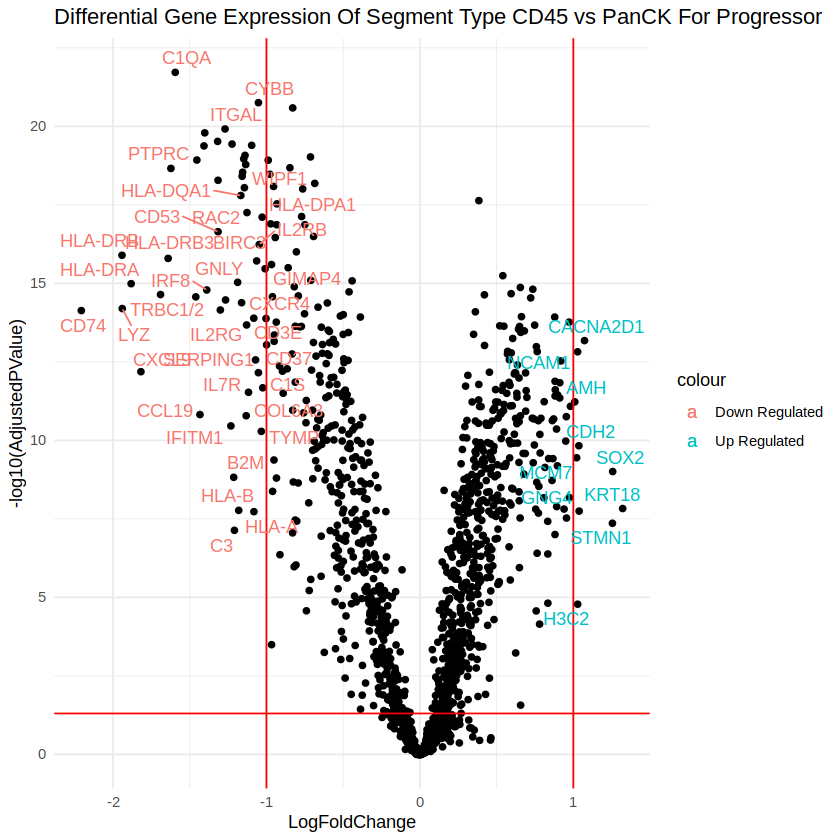

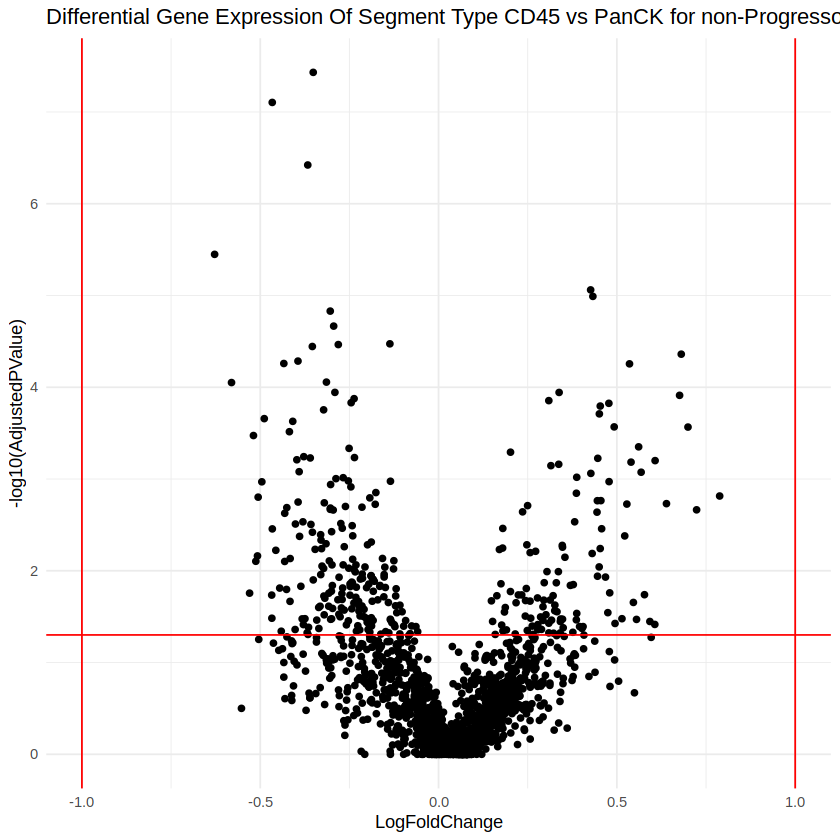

In [55]:
progRes$diffExpressed <- "NO"

progRes$diffExpressed[(progRes$LogFoldChange < -1) & (progRes$AdjustedPValue < 0.05)] <- "DOWN"
progRes$diffExpressed[(progRes$LogFoldChange > 1) & (progRes$AdjustedPValue < 0.05)] <- "UP"

progResA <- progRes[1:1812,]
progResB <- progRes[1813:3624, ]


ggplot(data = progResA, aes(y = -log10(AdjustedPValue), x = LogFoldChange ), col = diffExpressed, 
       label = Gene) + geom_point() + theme_minimal() + geom_vline(xintercept=c(-1, 1), col="red") + 
         geom_hline(yintercept=-log10(0.05), col="red") + 
        geom_text_repel(data=subset(progResA, (diffExpressed == "UP") & AdjustedPValue < 0.05), 
                        aes(label=Gene, color = "Up Regulated")) + 
        geom_text_repel(data=subset(progResA, (diffExpressed == "DOWN") & AdjustedPValue < 0.05), 
                        aes(label=Gene, color = "Down Regulated")) + 
        ggtitle("Differential Gene Expression Of Segment Type CD45 vs PanCK For Progressor")
        
ggplot(data = progResB, aes(y = -log10(AdjustedPValue), x = LogFoldChange ), col = diffExpressed, 
       label = Gene) + geom_point() + theme_minimal() + geom_vline(xintercept=c(-1, 1), col="red") + 
         geom_hline(yintercept=-log10(0.05), col="red") + 
        geom_text_repel(data=subset(progResB, (diffExpressed == "UP") & AdjustedPValue < 0.05), 
                        aes(label=Gene, color = "Up Regulated")) + 
        geom_text_repel(data=subset(progResB, (diffExpressed == "DOWN") & AdjustedPValue < 0.05), 
                        aes(label=Gene, color = "Down Regulated")) + 
        ggtitle("Differential Gene Expression Of Segment Type CD45 vs PanCK for non-Progressor")



The differential gene expression volcano plots. The segmentation differential gene expression shows better results than the progressor vs non-progressor plots. This shows that a lot more signal is present in segmentation than in progressor. The DGE analysis is performed by using a for loop to range through all genes in a particular condition. It is also possible to choose the log fold change and p value cutoffs. The results are saved in a dataframe for easy access later on. Each row corresponds to one instance of the linear mixed effect model (i.e. one gene for one comparison). The volcano plot shows the log fold change vs p-value for each row corresponding to a specific comparison. The number of genes determine where one condition begins and the other ends (should change this). 


In [19]:
finalDf$AdjustedPValue <- as.numeric(finalDf$AdjustedPValue)

In [16]:
# TODO: Combine code above into one for more flexible/cleaner code. Will want the same code for both comparisons 
# TODO: Add a column to dataframe that denotes the current comparison.

finalDf$diffExpressed <- "NO"

finalDf$diffExpressed[(finalDf$LogFoldChange < -1) & (finalDf$AdjustedPValue < 0.05)] <- "DOWN"
finalDf$diffExpressed[(finalDf$LogFoldChange > 1) & (finalDf$AdjustedPValue < 0.05)] <- "UP"


ggplot(data = finalDf, aes(y = -log10(AdjustedPValue), x = LogFoldChange ), col = diffExpressed, 
       label = Gene) + geom_point() + theme_minimal() + geom_vline(xintercept=c(-1, 1), col="red") + 
         geom_hline(yintercept=-log10(0.05), col="red") + 
        geom_text_repel(data=subset(finalDf, (diffExpressed == "UP") & AdjustedPValue < 0.05), 
                        aes(label=Gene, color = "Up Regulated")) + 
        geom_text_repel(data=subset(finalDf, (diffExpressed == "DOWN") & AdjustedPValue < 0.05), 
                        aes(label=Gene, color = "Down Regulated")) + 
        ggtitle("Differential Gene Expression Of Segment Type CD45 vs PanCK for non-Progressor")

In [ ]:
#geneDf$segment <- factor(geneDf$segment, levels = c(TRUE, FALSE), labels = c("panCK", "CD45"))

geneDf <- featureDf[featureDf$TargetName == "TSHR",]

lmeres <- lmer(count ~ 0 + (segment) + (1|slide) , data = geneDf, REML = TRUE)
anova(lmeres)$Sum
anova(lmeres)$Mean
anova(lmeres)$F
anova(lmeres)
as.vector(fixef(lmeres))


In [7]:
TSHRdata <- longData[longData$TargetName == "TSHR",]
TSHRpanCKonly <- (TSHRdata[TSHRdata$segment,])

In [11]:
panCKonly <- (longData[longData$segment,])
cd45only <- longData[!longData$segment,]
progressorOnly <- longData[longData$progressor,]
nonProgressorOnly <- longData[!longData$progressor,]


In [13]:
longData$progressor <- factor(longData$progressor, levels = c(FALSE, TRUE), labels = c('non_progressor', 'progressor'))
longData$segment <- factor(longData$segment, levels = c(TRUE, FALSE), labels = c("panCK", "CD45"))



In [10]:

TSHRpanCKonly$progressor <- factor(TSHRpanCKonly$progressor, levels = c(FALSE, TRUE), labels = c('non_progressor', 'progressor'))



In [63]:
TSHRpanCKonly$sample <- str_split_fixed(TSHRpanCKonly$sample, "\\.", 2)[,1]

In [2]:
fd <- "panCK"
rownum <- 0

featureDfs <- list(panCKonly, cd45only)

finalDf <- data.frame(Gene = c("Gene"), Mean1 = c(1), Mean2 = c(1), LogFoldChange = c(1), AdjustedPValue = c(1), 
                     IsSingular = c(TRUE), Condition = fd)

for (featureDf in featureDfs){

for (geneName in geneList){
        #print(geneName)
        geneDf <- featureDf[featureDf$TargetName == geneName,]
        lmeres <- lmer(count ~ 0 + (progressor) + (1|slide) , data = geneDf, REML = TRUE)
        
        mean1 <- mean((geneDf[geneDf$progressor,])$count)
        mean2 <- mean((geneDf[!(geneDf$progressor), ])$count)
        
        log2FoldChange <- mean1 - mean2
        
        contrast.matrix = rbind(
            `Group1 vs. Group2` = c(-1,1) ## R vs NR
              )


        comp.z = glht(lmeres, contrast.matrix)
        
        comp.t <- contest(lmeres, L= contrast.matrix, joint = FALSE, ddf='Satterthwaite', check_estimability = TRUE)

        compAdjusted <- p.adjust(comp.t, method = "BH")

        adjustedPvalue <- as.vector(compAdjusted[7])
        
        #TODO get all the results necessary 
        #TODO figure out how to deal with singular matrices (i.e. slide is same as progressor) 
            # Can maybe use AOI number?
        
        results <- c(geneName, mean1, mean2, log2FoldChange, adjustedPvalue, isSingular(lmeres), fd)
        #print(results)
        finalDf[rownum, ] <- results
        
        rownum <- rownum + 1
        
        
        
    
    
}

    fd <- "cd45"
    }



ERROR: Error in parse(text = x, srcfile = src): <text>:1:3: unexpected string constant
27:         
28:         comp.t <- contest(lmeres, L= contrast.matrix, joint = FALSE, ddf='
      ^


In [7]:
write.csv(x = finalDf, '/jet/home/gfonseca/repos/UPMC HCC/progressorRun.csv')

In [ ]:
head(finalDf)

finalDf$AdjustedPValue <- as.numeric(finalDf$AdjustedPValue)
finalDf$LogFoldChange <- as.numeric(finalDf$LogFoldChange)

In [152]:


finalDf2 <- read.csv("./progressorRun.csv")

# TODO: Modularize volcano plot / heatmap code


Warning message:
“ggrepel: 18 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


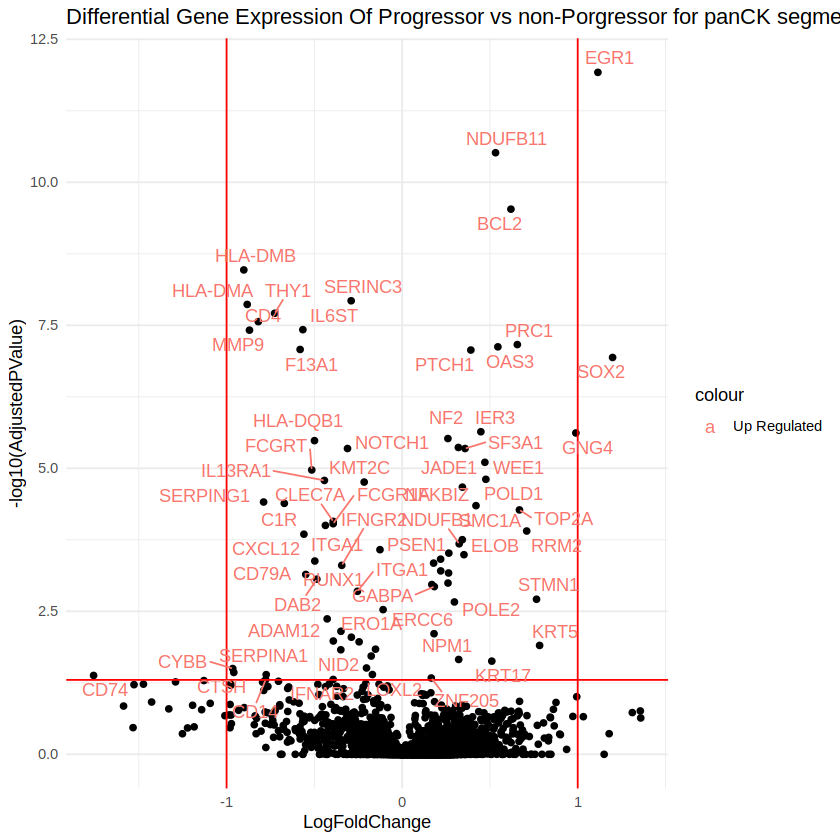

In [7]:
finalDf2$diffExpressed <- "NO"

finalDf2$diffExpressed[(finalDf2$LogFoldChange < -1) & (finalDf2$AdjustedPValue < 0.05)] <- "DOWN"
finalDf2$diffExpressed[(finalDf2$LogFoldChange > 1) & (finalDf2$AdjustedPValue < 0.05)] <- "UP"


ggplot(data = finalDf2, aes(y = -log10(AdjustedPValue), x = LogFoldChange ), col = diffExpressed, 
       label = Gene) + geom_point() + theme_minimal() + geom_vline(xintercept=c(-1, 1), col="red") + 
         geom_hline(yintercept=-log10(0.05), col="red") + 
        geom_text_repel(data=subset(finalDf2, (diffExpressed == "UP") & AdjustedPValue < 0.05), 
                        aes(label=Gene, color = "Up Regulated")) + 
        geom_text_repel(data=subset(finalDf2, (diffExpressed == "DOWN") & AdjustedPValue < 0.05), 
                        aes(label=Gene, color = "Down Regulated")) + 
        ggtitle("Differential Gene Expression Of Progressor vs non-Porgressor for panCK segment")

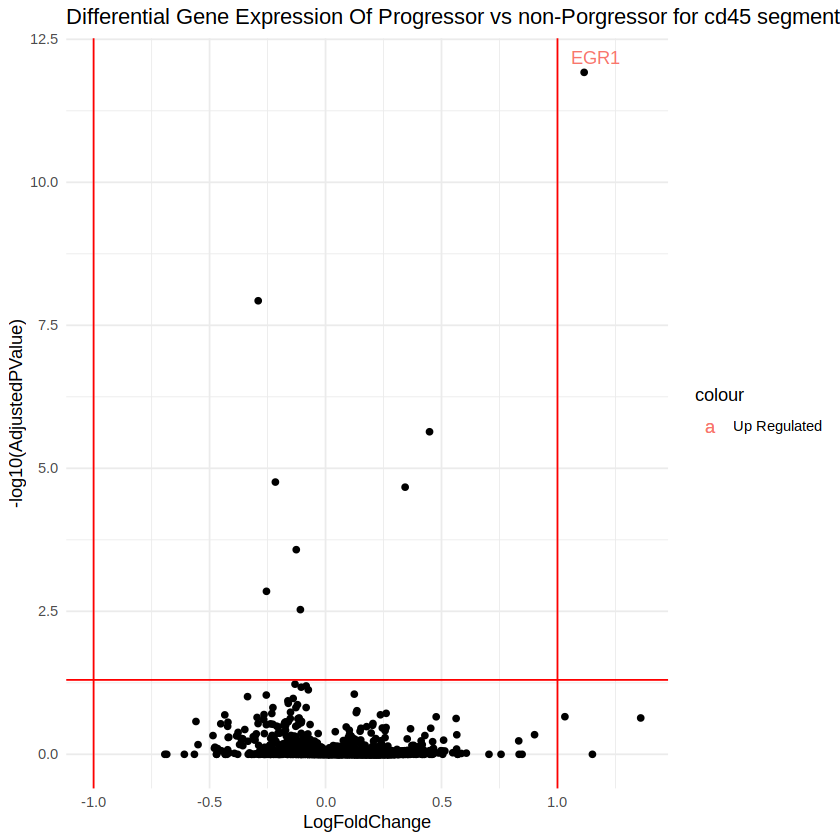

In [25]:
finalDf2 <- finalDf[finalDf$Condition == "cd45",]

ggplot(data = finalDf2, aes(y = -log10(AdjustedPValue), x = LogFoldChange ), col = diffExpressed, 
       label = Gene) + geom_point() + theme_minimal() + geom_vline(xintercept=c(-1, 1), col="red") + 
         geom_hline(yintercept=-log10(0.05), col="red") + 
        geom_text_repel(data=subset(finalDf2, (diffExpressed == "UP") & AdjustedPValue < 0.05), 
                        aes(label=Gene, color = "Up Regulated")) + 
        geom_text_repel(data=subset(finalDf2, (diffExpressed == "DOWN") & AdjustedPValue < 0.05), 
                        aes(label=Gene, color = "Down Regulated")) + 
        ggtitle("Differential Gene Expression Of Progressor vs non-Porgressor for cd45 segment")

Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


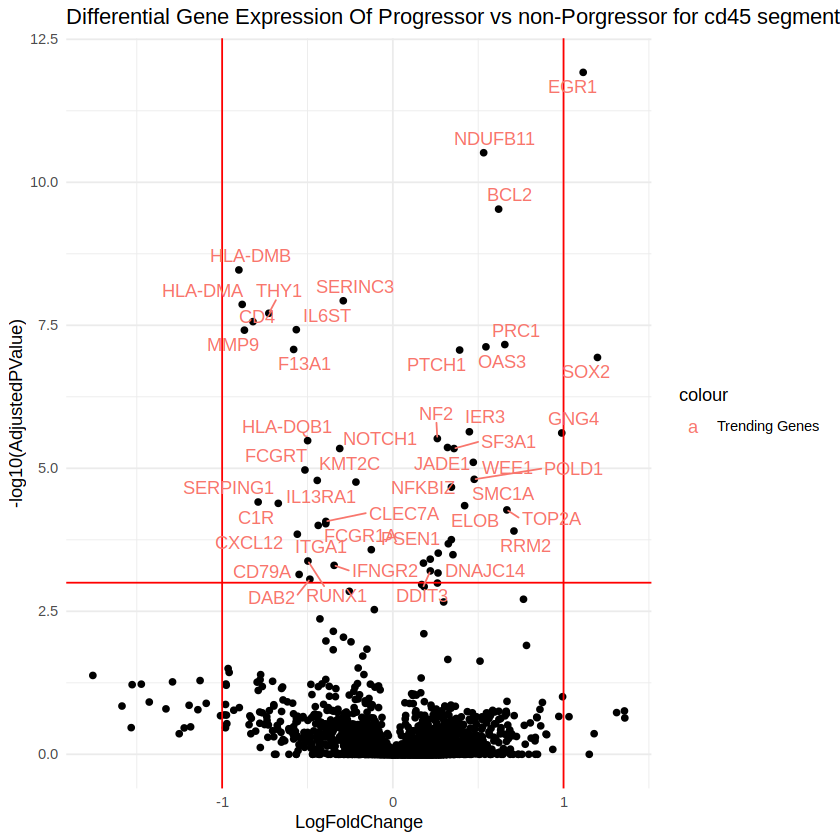

In [9]:
ggplot(data = finalDf2, aes(y = -log10(AdjustedPValue), x = LogFoldChange ), col = diffExpressed, 
       label = Gene) + geom_point() + theme_minimal() + geom_vline(xintercept=c(-1, 1), col="red") + 
         geom_hline(yintercept=-log10(0.001), col="red") + 
        geom_text_repel(data=subset(finalDf2, AdjustedPValue < 0.001), 
                        aes(label=Gene, color = "Trending Genes")) + 
        ggtitle("Differential Gene Expression Of Progressor vs non-Porgressor for cd45 segment")

In [153]:
annProgressor <- testcat[,1:2]
annSegment <- testcat
annSegment$segment <- NULL


In [154]:

cd45 <- finalDf2[finalDf2$Condition == "cd45", ]

cd45UP <- cd45[cd45$LogFoldChange > 0 ,]
cd45DOWN <- cd45[cd45$LogFoldChange < 0, ]

top25up <- arrange(cd45UP, -abs(LogFoldChange))$Gene[1:25]
top25down <- arrange(cd45DOWN, -abs(LogFoldChange))$Gene[1:25]

geneAnnDf <- data.frame(Gene = c(top25up, top25down), Sign = "up regulated")
rownames(geneAnnDf) <- geneAnnDf$Gene
geneAnnDf$Sign[geneAnnDf$Gene %in% top25down] <- "down regulated"
geneAnnDf$Gene <- NULL




In [155]:

upbool <- normData$TargetName %in% top25up

downbool <- normData$TargetName %in% top25down

allbool <- upbool | downbool

cd45SegmentMatrix <- normData[allbool,]

rownames(cd45SegmentMatrix) <- cd45SegmentMatrix$TargetName

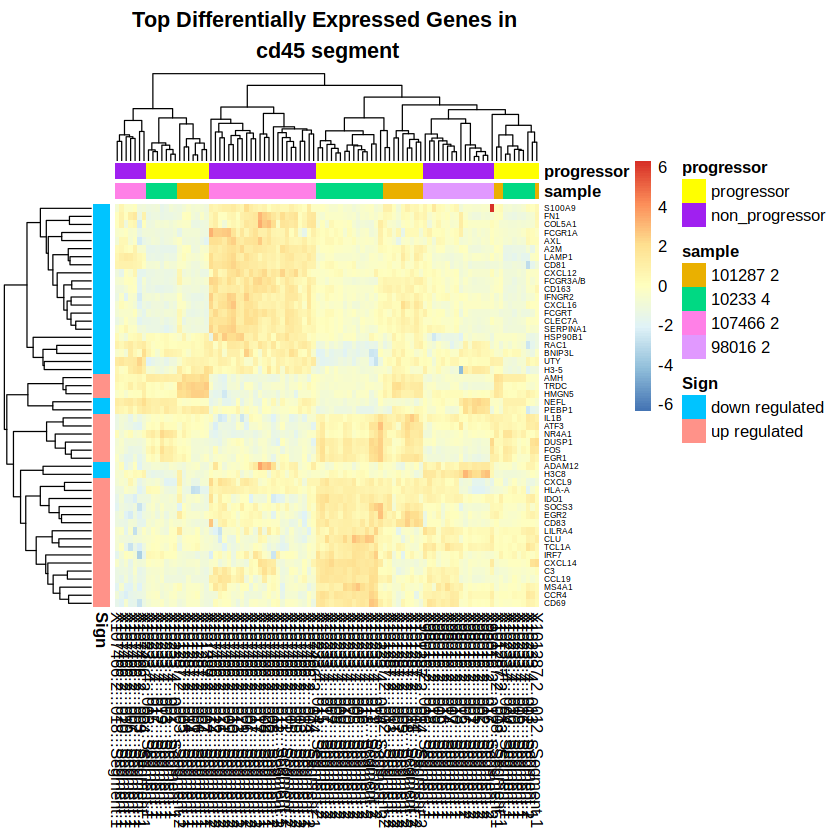

In [156]:


cd45SegmentMatrix$TargetName <- NULL

cd45SegmentMatrix$X <- NULL

pheatmap(cd45SegmentMatrix, scale = "row", annotation = annSegment, main="Top Differentially Expressed Genes in 
cd45 segment", annotation_colors = ann_colors, fontsize_row = 5, annotation_row = geneAnnDf)

#TODO: Sort up and down regulated for cleaner heatmap 
#TODO: Modularize heatmap code
#TODO: Display DGE log fold change for each gene in heatmap 


Annotated heatmap containing the top differentially expressed genes. Each heatmap uses similar code, using the log expression of each sample for the top 25 up regulated and top 25 downregulated genes for each condition. This may result in differences in log fold change across the board (i.e. some low fold change genes present), so it may be useful to display the log fold change for each gene. Each condition contains different genes as well, but it's interesting that the results are more promising than that of the volcano plot. The heatmaps use pheatmap, so annotation is also possible. The same annotation data frame may be used for each heatmap; we are using the same sample names afterall. For annotating down and up regulated, the gene names may be obtained from rownames of the expression matrix, and the sign (up or down) can be obtained from the corresponding DGE data frame results (i.e. in the LogFoldChange column). 

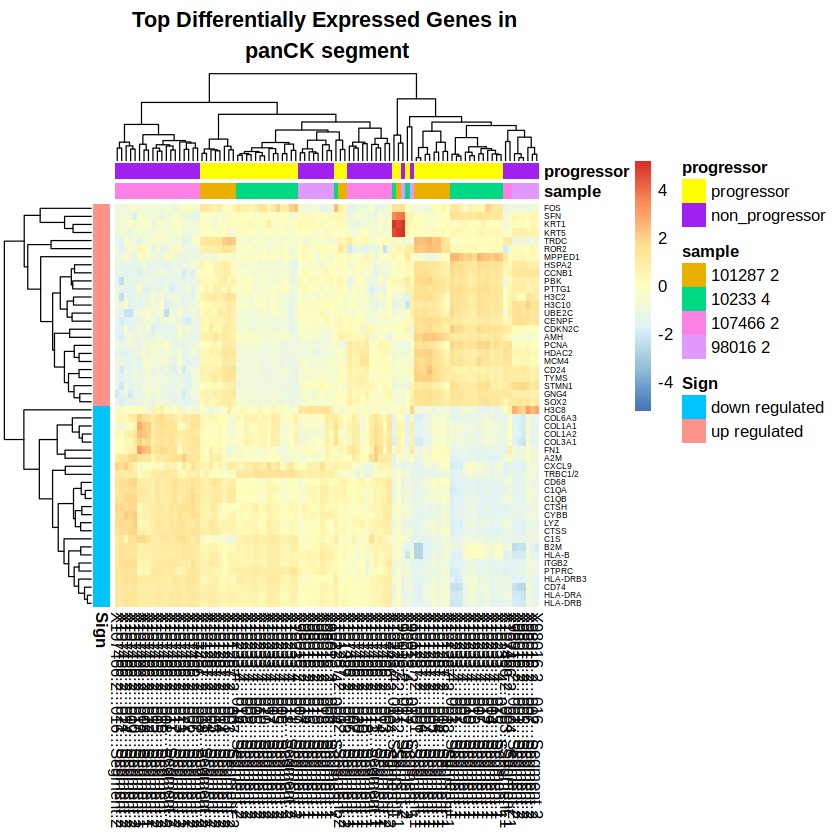

In [157]:
cd45 <- finalDf2[finalDf2$Condition == "panCK", ]

cd45UP <- cd45[cd45$LogFoldChange > 0 ,]
cd45DOWN <- cd45[cd45$LogFoldChange < 0, ]

top25up <- arrange(cd45UP, -abs(LogFoldChange))$Gene[1:25]
top25down <- arrange(cd45DOWN, -abs(LogFoldChange))$Gene[1:25]

geneAnnDf <- data.frame(Gene = c(top25up, top25down), Sign = "up regulated")
rownames(geneAnnDf) <- geneAnnDf$Gene
geneAnnDf$Sign[geneAnnDf$Gene %in% top25down] <- "down regulated"
geneAnnDf$Gene <- NULL


upbool <- normData$TargetName %in% top25up

downbool <- normData$TargetName %in% top25down

allbool <- upbool | downbool

cd45SegmentMatrix <- normData[allbool,]

rownames(cd45SegmentMatrix) <- cd45SegmentMatrix$TargetName

cd45SegmentMatrix$TargetName <- NULL

cd45SegmentMatrix$X <- NULL

pheatmap(cd45SegmentMatrix, scale = "row", annotation = annSegment, main = "Top Differentially Expressed Genes in 
panCK segment", annotation_colors = ann_colors, fontsize_row = 5, annotation_row = geneAnnDf)

In [158]:
finalDf2 <- read.csv("./segmentRun.csv")

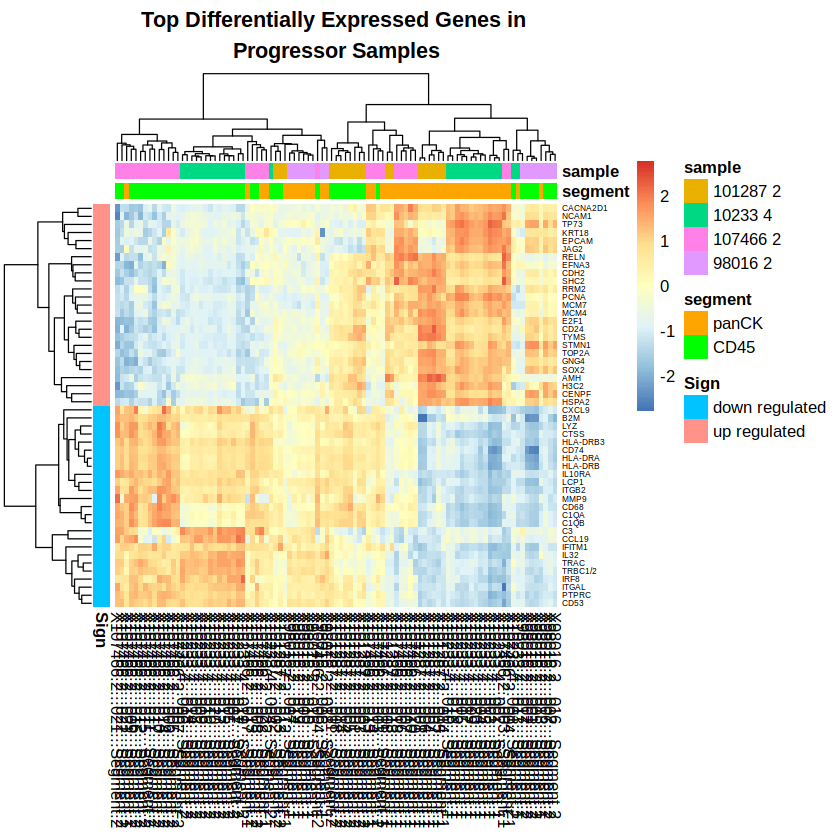

In [159]:
cd45 <- finalDf2[finalDf2$Condition == "progressor", ]

cd45UP <- cd45[cd45$LogFoldChange > 0 ,]
cd45DOWN <- cd45[cd45$LogFoldChange < 0, ]

top25up <- arrange(cd45UP, -abs(LogFoldChange))$Gene[1:25]
top25down <- arrange(cd45DOWN, -abs(LogFoldChange))$Gene[1:25]

geneAnnDf <- data.frame(Gene = c(top25up, top25down), Sign = "up regulated")
rownames(geneAnnDf) <- geneAnnDf$Gene
geneAnnDf$Sign[geneAnnDf$Gene %in% top25down] <- "down regulated"
geneAnnDf$Gene <- NULL


upbool <- normData$TargetName %in% top25up

downbool <- normData$TargetName %in% top25down

allbool <- upbool | downbool

cd45SegmentMatrix <- normData[allbool,]

rownames(cd45SegmentMatrix) <- cd45SegmentMatrix$TargetName

cd45SegmentMatrix$TargetName <- NULL

cd45SegmentMatrix$X <- NULL

pheatmap(cd45SegmentMatrix, scale = "row", annotation=annProgressor, main = "Top Differentially Expressed Genes in 
Progressor Samples", annotation_colors = ann_colors, annotation_row = geneAnnDf, fontsize_row = 5)

Segmentation heatmaps for sanity check. The results are strong showing clear signal differences between panCK and cd45 segments. This suggests that the data is reliable for most samples. 

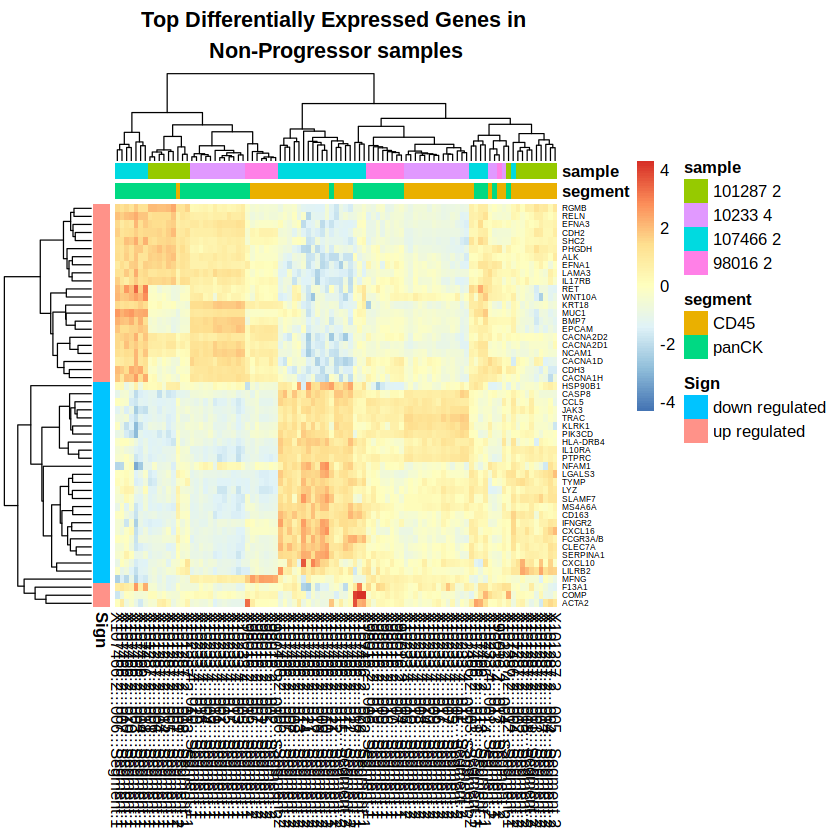

In [160]:
cd45 <- finalDf2[finalDf2$Condition == "non-progressor", ]

cd45UP <- cd45[cd45$LogFoldChange > 0 ,]
cd45DOWN <- cd45[cd45$LogFoldChange < 0, ]

top25up <- arrange(cd45UP, -abs(LogFoldChange))$Gene[1:25]
top25down <- arrange(cd45DOWN, -abs(LogFoldChange))$Gene[1:25]

geneAnnDf <- data.frame(Gene = c(top25up, top25down), Sign = "up regulated")
rownames(geneAnnDf) <- geneAnnDf$Gene
geneAnnDf$Sign[geneAnnDf$Gene %in% top25down] <- "down regulated"
geneAnnDf$Gene <- NULL





upbool <- normData$TargetName %in% top25up

downbool <- normData$TargetName %in% top25down

allbool <- upbool | downbool

cd45SegmentMatrix <- normData[allbool,]

rownames(cd45SegmentMatrix) <- cd45SegmentMatrix$TargetName

cd45SegmentMatrix$TargetName <- NULL

cd45SegmentMatrix$X <- NULL

pheatmap(cd45SegmentMatrix, scale = "row", annotation_col=annProgressor, main = "Top Differentially Expressed Genes in 
Non-Progressor samples", fontsize_row = 5, annotation_row = geneAnnDf)

In [116]:
geneAnnDf <- data.frame(Gene = c(top25up, top25down), Sign = "up")

In [118]:
geneAnnDf$Sign[geneAnnDf$Gene %in% top25down] <- "down"

In [38]:
testcat$progressor <- NULL